In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('../../Data/twoBlob.csv',header=None)
print(data.shape)
data.head()

(50459, 5)


,0,1,2,3,4
0,-0.99628,0.021094,0.058946,-0.044321,0.039304
1,-0.99301,0.019296,0.004439,0.013207,0.115630
2,-0.99179,-0.047079,-0.094503,-0.072077,-0.000892
3,-0.98819,-0.073798,0.068475,-0.114730,0.013236
4,-0.98270,-0.019260,-0.134410,0.030291,-0.122280


In [3]:
np.random.shuffle(data.values)
data.head()

,0,1,2,3,4
0,1.0580,0.144600,0.000000,0.00000,0.00000
1,3.5271,0.412280,-0.084929,-0.50320,-0.58819
2,4.8040,-0.090453,0.242500,0.48161,0.23384
3,1.7287,-0.171640,0.000000,0.00000,0.00000
4,1.1433,0.394330,0.000000,0.00000,0.00000


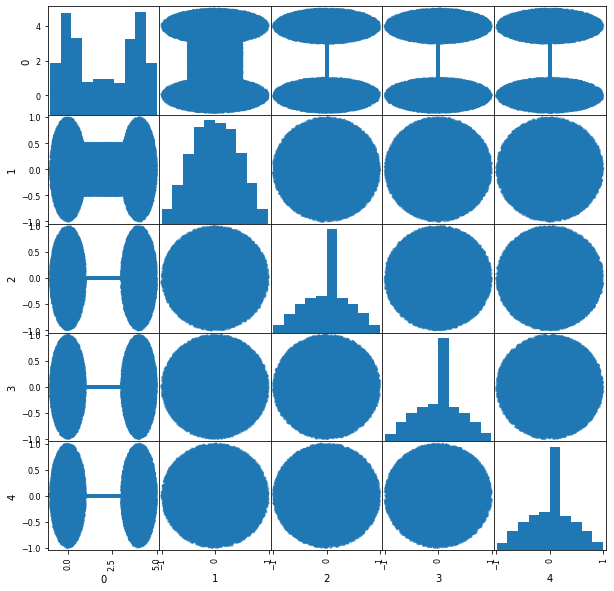

In [4]:
pd.plotting.scatter_matrix(data,figsize=[10,10]);

In [5]:
#estimate max distance
def _rand():
    return random.randint(0,data.shape[0])
def _dist(v1,v2):
    return sqrt(sum((v1-v2)**2))

D=[]
for i in range(40000):
    v1=np.array(data.iloc[_rand(),:])
    v2=np.array(data.iloc[_rand(),:])
    D.append(_dist(v1,v2))

5.8726257726278295


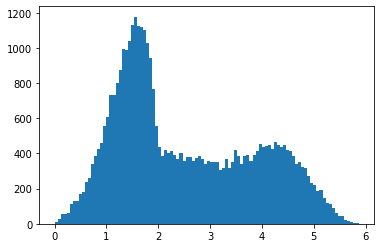

In [6]:
eps=max(D)
print(eps)
hist(D,bins=100);

In [7]:
eps

5.8726257726278295

In [29]:
class CoverTree(object):
    def __init__(self,center,radius,path):
        self.center=center
        self.radius=radius
        self.counter=1  # number of points covered by this tree
        self.too_far=0  # count how many points were too far (should only be non-zero at root
        self.path=path
        self.children = []
    
    def no_of_children(self):
        return len(self.children)
    def get_level(self):
        return len(self.path)
    
    def find_path(self,x):
        d= _dist(x,self.center)
        #print(str(self.path),d)
        if d>self.radius:
             return None
        if len(self.children)==0:
            return [self]
        else:
            for child in self.children:
                child_path = child.find_path(x)
                if child_path is None:
                    continue
                else:
                    return [self]+child_path
            return [self]

    def insert(self,x):
        path=self.find_path(x)
        if path is None:
            return False

        #found a non-trivial path
        leaf=path[-1]
        new=CoverTree(x,leaf.radius/2,leaf.path+(leaf.no_of_children(),))
        leaf.children.append(new)
        for node in path:
            node.counter +=1
        return True
            
        
    def collect_centers(self):
        '''Collect all of the centers defined by a tree
        returns a list where each element is a center, followed by the level of the center'''
        C=[(self.center,len(self.path))]
        if len(self.children)>0:
            for child in self.children:
                C = C+ child.collect_centers()
        return C
            
    def collect_nodes(self):
        '''returns a list of all nodes in the tree'''
        N=[self]
        if len(self.children)>0:
            for child in self.children:
                N=N+child.collect_nodes()
        return N

    def __str__(self):
        return str(self.path)+': r=%4.2f, no_child=%d, count=%d'%(self.radius,len(self.children),self.counter)

    def _str_to_level(self,max_level):
        s=self.__str__()+'\n'
        if self.get_level() < max_level and len(self.children)>0:
            for i in range(len(self.children)):
                s+=self.children[i]._str_to_level(max_level)
        return s    

In [30]:
class MuffledTree(CoverTree):
    def __init__(self,center,radius,path):
        super().__init__(center,radius,path)
        self.covered_fraction = 0
        self.punch_through = False
    
    def insert(self,x):
        path=self.find_path(x)
        if path is None:
            return False

        #found a non-trivial path
        leaf=path[-1]
        is_root=len(path)==1
        if is_root:
            new=MuffledTree(x,leaf.radius/2,leaf.path+(leaf.no_of_children(),))
            leaf.children.append(new)
        else:  #not root
            parent = path[-2]
            if parent.punch_through: #add new node
                new=MuffledTree(x,leaf.radius/2,leaf.path+(leaf.no_of_children(),))
                leaf.children.append(new)
                if not parent.punch_through:
                    parent.covered_fraction = (1-alpha)*parent.covered_fraction
            else:     #don't add new node, instead, update parent statistics
                parent.covered_fraction = (1-alpha)*parent.covered_fraction + alpha
                if not parent.punch_through and parent.covered_fraction>thr:
                    print('node'+str(parent.path)+\
                          'punched through frac=%7.5f, count= %d, siblings=%2d'%(parent.covered_fraction,parent.counter,parent.no_of_children()))
                    parent.punch_through=True  # this is a latch, once the leaf is punched through it remains so forever
            
        for node in path:
            node.counter +=1
        return True

    def __str__(self):
        return str(self.path)+': r=%4.2f, no_child=%d, count=%d, cov_frac=%4.3f, punch_through=%1d'\
                %(self.radius,len(self.children),self.counter,self.covered_fraction,int(self.punch_through))

def gen_scatter(T,data,level=0):
    C=[]
    for i in range(data.shape[0]):
        point=np.array(data.iloc[i,:])
        C.append(T.find_path(point)[-1].path[level])

    figure(figsize=[15,5])
    scatter(data[0],data[1],s=1,c=C,alpha=0.2)
    t='Level=%d, colors=%d'%(level,max(C)+1)
    title(t);

In [38]:
thr=0.9
alpha=0.1
point=np.array(data.iloc[0,:])
T=MuffledTree(point,eps,())
print(T._str_to_level(1))

(): r=5.87, no_child=0, count=1, cov_frac=0.000, punch_through=0



In [39]:
for i in range(1,data.shape[0]):
#for i in range(1,2000):
    point=np.array(data.iloc[i,:])
    T.insert(point)

node()punched through frac=0.90152, count= 24, siblings= 2
node(0,)punched through frac=0.90152, count= 41, siblings= 3
node(1,)punched through frac=0.90152, count= 30, siblings= 2
node(0, 1)punched through frac=0.90152, count= 33, siblings= 4
node(0, 0)punched through frac=0.90152, count= 47, siblings=16
node(1, 0)punched through frac=0.90152, count= 57, siblings=18
node(1, 1)punched through frac=0.90152, count= 37, siblings=10
node(0, 2)punched through frac=0.90152, count= 41, siblings=13
node(0, 1, 0)punched through frac=0.90152, count= 41, siblings= 6
node(0, 1, 2)punched through frac=0.90152, count= 36, siblings= 5
node(0, 3)punched through frac=0.90152, count= 30, siblings= 8
node(0, 0, 5)punched through frac=0.90152, count= 33, siblings= 7
node(0, 1, 2, 0)punched through frac=0.90152, count= 45, siblings= 6
node(0, 1, 0, 0)punched through frac=0.90152, count= 34, siblings= 5
node(0, 1, 2, 2)punched through frac=0.90152, count= 26, siblings= 4
node(0, 1, 0, 1)punched through frac

node(1, 2, 1)punched through frac=0.90152, count= 46, siblings=14
node(0, 1, 0, 3, 1)punched through frac=0.90152, count= 31, siblings= 5
node(1, 1, 17)punched through frac=0.90152, count= 32, siblings=10
node(0, 5, 0)punched through frac=0.90152, count= 47, siblings= 9
node(0, 1, 2, 1)punched through frac=0.90152, count= 25, siblings= 3
node(0, 2, 9)punched through frac=0.90152, count= 35, siblings=12
node(0, 0, 20)punched through frac=0.90152, count= 32, siblings=10
node(1, 2, 0)punched through frac=0.90152, count= 41, siblings=13
node(1, 0, 18)punched through frac=0.90152, count= 32, siblings=10
node(0, 3, 4)punched through frac=0.90152, count= 35, siblings=12
node(0, 0, 17)punched through frac=0.90152, count= 33, siblings=11
node(0, 1, 5, 0)punched through frac=0.90152, count= 44, siblings= 3
node(0, 2, 13)punched through frac=0.90152, count= 31, siblings= 9
node(0, 0, 23)punched through frac=0.90152, count= 35, siblings=13
node(0, 1, 3, 0)punched through frac=0.90152, count= 33, s

node(0, 1, 3, 2)punched through frac=0.90152, count= 46, siblings=22
node(0, 1, 0, 4, 0, 1)punched through frac=0.90152, count= 36, siblings= 5
node(0, 1, 0, 3, 1, 0)punched through frac=0.90152, count= 41, siblings= 6
node(0, 1, 2, 0, 2, 1)punched through frac=0.90152, count= 30, siblings= 5
node(0, 1, 0, 1, 6)punched through frac=0.90152, count= 23, siblings= 1
node(0, 1, 0, 0, 7)punched through frac=0.90152, count= 24, siblings= 2
node(0, 1, 0, 1, 3, 2)punched through frac=0.90152, count= 33, siblings= 4
node(0, 1, 0, 1, 1, 2)punched through frac=0.90152, count= 36, siblings= 6
node(0, 1, 0, 1, 0, 3)punched through frac=0.90152, count= 28, siblings= 3
node(0, 1, 5, 0, 0, 0)punched through frac=0.90152, count= 47, siblings=10
node(0, 0, 5, 0, 3, 0)punched through frac=0.90152, count= 41, siblings= 6
node(1, 2, 4)punched through frac=0.90152, count= 28, siblings= 5
node(1, 1, 14)punched through frac=0.90152, count= 30, siblings= 8
node(0, 1, 2, 0, 0, 2)punched through frac=0.90152, co

node(1, 0, 0, 4)punched through frac=0.90152, count= 53, siblings=28
node(0, 1, 0, 2, 0, 0)punched through frac=0.90152, count= 39, siblings= 5
node(0, 0, 18, 8)punched through frac=0.90152, count= 42, siblings=19
node(1, 0, 3, 7)punched through frac=0.90152, count= 41, siblings=17
node(1, 0, 3, 1)punched through frac=0.90152, count= 53, siblings=25
node(1, 0, 5, 4)punched through frac=0.90152, count= 41, siblings=16
node(1, 0, 12, 4)punched through frac=0.90152, count= 46, siblings=17
node(0, 0, 5, 5)punched through frac=0.90152, count= 43, siblings=21
node(1, 0, 9, 0)punched through frac=0.90152, count= 51, siblings=26
node(1, 0, 1, 16)punched through frac=0.90152, count= 42, siblings=20
node(1, 0, 3, 12)punched through frac=0.90152, count= 36, siblings=13
node(0, 1, 5, 1)punched through frac=0.90152, count= 26, siblings= 2
node(1, 0, 5, 2)punched through frac=0.90152, count= 37, siblings=15
node(1, 1, 9, 2)punched through frac=0.90152, count= 46, siblings=17
node(1, 0, 5, 3)punched 

In [33]:
print(T._str_to_level(2))

(): r=5.87, no_child=2, count=50459, cov_frac=0.990, punch_through=1
(0,): r=2.94, no_child=6, count=31199, cov_frac=0.990, punch_through=1
(0, 0): r=1.47, no_child=16, count=11832, cov_frac=0.990, punch_through=1
(0, 1): r=1.47, no_child=42, count=11027, cov_frac=0.990, punch_through=1
(0, 2): r=1.47, no_child=31, count=6197, cov_frac=0.990, punch_through=1
(0, 3): r=1.47, no_child=13, count=1746, cov_frac=0.990, punch_through=1
(0, 4): r=1.47, no_child=3, count=54, cov_frac=0.395, punch_through=0
(0, 5): r=1.47, no_child=3, count=48, cov_frac=0.357, punch_through=0
(1,): r=2.94, no_child=4, count=19259, cov_frac=0.990, punch_through=1
(1, 0): r=1.47, no_child=44, count=10423, cov_frac=0.990, punch_through=1
(1, 1): r=1.47, no_child=34, count=6666, cov_frac=0.990, punch_through=1
(1, 2): r=1.47, no_child=15, count=1694, cov_frac=0.990, punch_through=1
(1, 3): r=1.47, no_child=5, count=310, cov_frac=0.949, punch_through=0



In [40]:
Nodes = T.collect_nodes()
C=[]
for node in Nodes:
    if node.punch_through:
        n=node.no_of_children()
        d=log(n)/log(2.)
        if n<8:
            C.append((node.center,d,node.path)) 
centers=np.array([c[0] for c in C])
D=[c[1] for c in C]
max_d=max(D)
S=[(max_d+3-d)*50 for d in D]

175


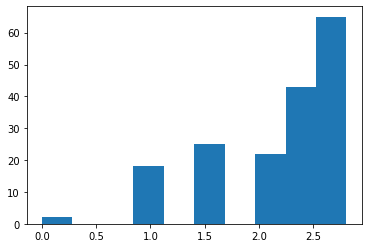

In [44]:
print(len(C))
hist(D);

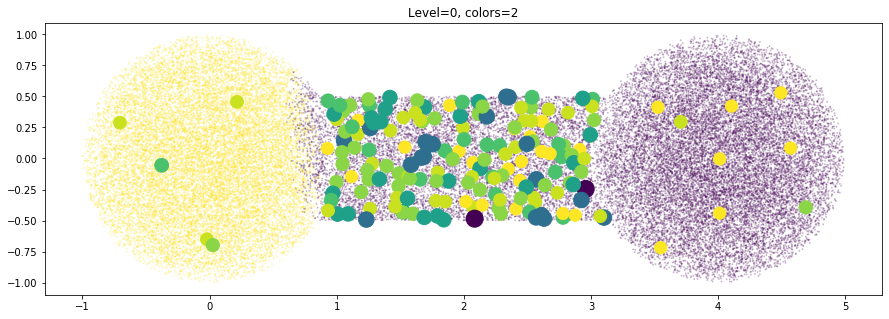

In [43]:
gen_scatter(T,data,level=0)
scatter(centers[:,0],centers[:,1],c=D,s=S)

## Suppressing high dimension regions
By collecting only nodes that have at most 6 children we concentrate our samples on the 1D connector